In [3]:
import pandas as pd
import numpy as np
import glob
import os

# 🔹 FOLDER that contains the CSV files (NOT the CSV itself)
DATA_DIR = r"C:/Users/HS COMPUTER/OneDrive/Desktop/EDA Tasks/Data Sets/beijing"

# 🔹 Find all station CSV files
station_files = glob.glob(os.path.join(DATA_DIR, "PRSA_Data_*.csv"))

# 🔹 Safety check
if not station_files:
    raise FileNotFoundError(
        f"No PRSA_Data_*.csv files found in folder: {DATA_DIR}"
    )

dfs = []

for file in station_files:
    df = pd.read_csv(file)
    
    # Extract station name
    # PRSA_Data_Dongsi_20130301-20170228.csv → Dongsi
    station_name = os.path.basename(file).split("_")[2]
    df["station"] = station_name
    
    dfs.append(df)

# 🔹 Merge all stations
data = pd.concat(dfs, ignore_index=True)

# 🔹 Create datetime index
data["datetime"] = pd.to_datetime(
    data[["year", "month", "day", "hour"]],
    errors="raise"
)

data = data.sort_values(["station", "datetime"]).set_index("datetime")

# 🔹 Sanity checks
print(f"Total records: {data.shape[0]}")
print(f"Total stations: {data['station'].nunique()}")

data.head()


Total records: 420768
Total stations: 12


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
datetime,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01 01:00:00,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01 02:00:00,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01 03:00:00,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01 04:00:00,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [5]:
# -------------------------------
# Column groups
# -------------------------------
pollution_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
weather_continuous = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
weather_categorical = ['wd']

# -------------------------------
# Time-based interpolation (continuous features)
# -------------------------------
for col in pollution_cols + weather_continuous:
    data[col] = (
        data.groupby('station')[col]
            .transform(lambda x: x.interpolate(method='time'))
    )

# -------------------------------
# Forward-fill categorical weather
# -------------------------------
for col in weather_categorical:
    data[col] = (
        data.groupby('station')[col]
            .transform(lambda x: x.ffill())
    )

# -------------------------------
# Final station-wise fallback (mean imputation)
# -------------------------------
for col in pollution_cols + weather_continuous:
    data[col] = (
        data.groupby('station')[col]
            .transform(lambda x: x.fillna(x.mean()))
    )


In [6]:
print("Total missing values:", data.isna().sum().sum())


Total missing values: 0


In [7]:
from sklearn.preprocessing import LabelEncoder

# 1. Create the Target Variable: Average of PM2.5 for the next 6 hours
# Logic: At time 't', we want the mean of PM2.5 from 't+1' to 't+6'
data['target'] = (
    data.groupby('station')['PM2.5']
    .transform(lambda x: x.rolling(window=6).mean().shift(-6))
)

# 2. Encode categorical weather direction ('wd') for the models
le = LabelEncoder()
data['wd_encoded'] = le.fit_transform(data['wd'].astype(str))

# 3. Define Features and Target
# Using pollution levels, weather, and encoded wind direction as features
features = pollution_cols + weather_continuous + ['wd_encoded']
target = 'target'

# 4. Remove rows where target is NaN (the last 6 hours of each station's record)
data_model = data.dropna(subset=[target]).copy()

print(f"Features used: {features}")
print(f"Data shape for modeling: {data_model.shape}")

Features used: ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_encoded']
Data shape for modeling: (420696, 20)


In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Define the custom metric: Capture Rate
def calculate_capture_rate(y_true, y_pred, threshold=0.15):
    """Percentage of predictions within 15% of actual values"""
    # Avoid division by zero
    mask = y_true != 0
    percentage_error = np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]
    return np.mean(percentage_error <= threshold)

# Prepare X and y
X = data_model[features]
y = data_model[target]

# Initialize TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Define models
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results_list = []

# Cross-Validation Loop
for name, model in models.items():
    print(f"Training {name}...")
    fold_metrics = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit model
        model.fit(X_train, y_train)
        # Predict
        preds = model.predict(X_test)
        
        # Calculate metrics for the fold
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        cr = calculate_capture_rate(y_test.values, preds)
        
        fold_metrics.append([rmse, mae, r2, cr])
    
    # Calculate average metrics across all 5 folds
    avg_metrics = np.mean(fold_metrics, axis=0)
    results_list.append({
        "Model": name,
        "RMSE": avg_metrics[0],
        "MAE": avg_metrics[1],
        "R2": avg_metrics[2],
        "Capture Rate (15%)": avg_metrics[3]
    })

# Display Results
comparison_df = pd.DataFrame(results_list)
print("\n--- Model Comparison Results (Averaged over 5 Time-Series Splits) ---")
display(comparison_df.sort_values(by="RMSE"))

Training Decision Tree...
Training Gradient Boosting...
Training Random Forest...

--- Model Comparison Results (Averaged over 5 Time-Series Splits) ---


,Model,RMSE,MAE,R2,Capture Rate (15%)
2,Random Forest,29.805615,17.877699,0.855888,0.405656
1,Gradient Boosting,32.001940,19.432239,0.834075,0.369901
0,Decision Tree,43.452646,25.835693,0.693755,0.311926


## Task 4: Spatio-Temporal Analysis
This section focuses on the spatial relationships between stations and how air quality patterns differ across Beijing.
1. **Station Clustering**: Grouping stations with similar pollution/weather profiles.
2. **Cluster-Specific Models**: Training separate Random Forest models for each cluster.
3. **Feature Importance**: Comparing what drives PM2.5 in different areas.
4. **Geographical Visualization**: Mapping errors across the city.
5. **Interactive Time-Series**: A Plotly dashboard to compare predictions vs. actuals.

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# --- FIX: Reset index to ensure unique identifiers for assignment ---
# This prevents the "ValueError: shape mismatch"
data_model = data_model.reset_index()

# 1. Prepare Station Profiles for Clustering
# We group by station to find their "average" behavior
station_profiles = data_model.groupby('station')[['PM2.5', 'TEMP', 'DEWP', 'WSPM']].mean()
scaler = StandardScaler()
scaled_profiles = scaler.fit_transform(station_profiles)

# Apply K-Means (3 clusters: e.g., Urban, Suburban, Rural)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
station_profiles['cluster'] = kmeans.fit_predict(scaled_profiles)

# Map clusters back to the main dataframe
cluster_map = station_profiles['cluster'].to_dict()
data_model['cluster'] = data_model['station'].map(cluster_map)

print("Station Cluster Assignments:")
print(station_profiles['cluster'])

# 2. Build Separate Models for Each Cluster
cluster_models = {}
feature_importances = []
data_model['prediction'] = np.nan # Initialize prediction column

for cluster_id in range(3):
    print(f"Training model for Cluster {cluster_id}...")
    cluster_data = data_model[data_model['cluster'] == cluster_id]
    
    # Simple Temporal Split (80% train, 20% test) for this cluster
    split_point = int(len(cluster_data) * 0.8)
    train_df = cluster_data.iloc[:split_point]
    test_df = cluster_data.iloc[split_point:]
    
    # Train Model
    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(train_df[features], train_df[target])
    
    # Store model and importance
    cluster_models[cluster_id] = model
    importances = pd.Series(model.feature_importances_, index=features)
    importances['cluster'] = cluster_id
    feature_importances.append(importances)
    
    # Assign predictions back using the unique index
    data_model.loc[test_df.index, 'prediction'] = model.predict(test_df[features])

print("\nAll cluster models trained and predictions assigned successfully.")

Station Cluster Assignments:
station
Aotizhongxin     1
Changping        0
Dingling         0
Dongsi           1
Guanyuan         1
Gucheng          1
Huairou          2
Nongzhanguan     1
Shunyi           1
Tiantan          1
Wanliu           1
Wanshouxigong    1
Name: cluster, dtype: int32
Training model for Cluster 0...
Training model for Cluster 1...
Training model for Cluster 2...

All cluster models trained and predictions assigned successfully.


### 3. Feature Importance Across Clusters
We visualize a heatmap to compare how different features influence the target (next 6-hour PM2.5) across the three station clusters.

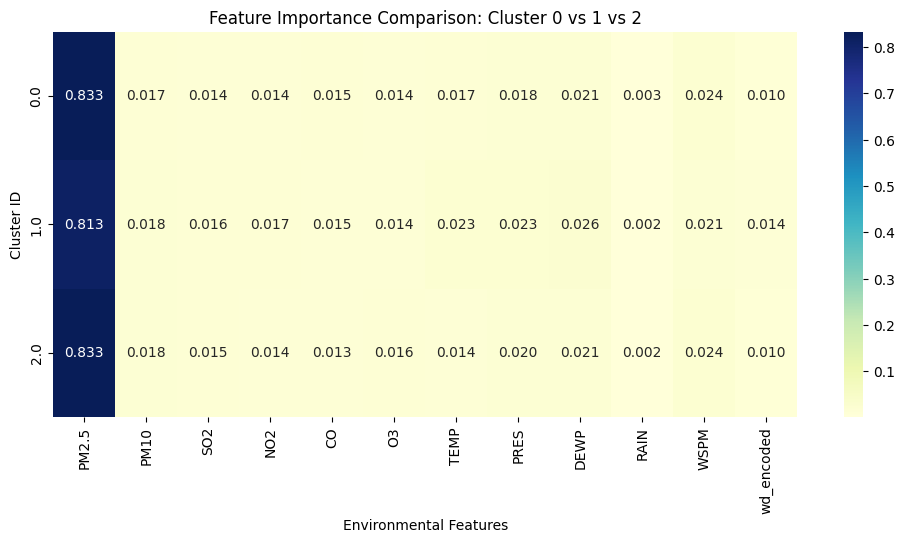

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert importance list to a DataFrame
fi_df = pd.DataFrame(feature_importances).set_index('cluster')

plt.figure(figsize=(12, 5))
sns.heatmap(fi_df, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title('Feature Importance Comparison: Cluster 0 vs 1 vs 2')
plt.xlabel('Environmental Features')
plt.ylabel('Cluster ID')
plt.show()

### 4. Geographical Error Analysis
We map the Root Mean Squared Error (RMSE) to the physical locations of the stations to see where the model performs best.

In [13]:
import plotly.express as px
from sklearn.metrics import mean_squared_error

# 1. Standard Beijing Station Coordinates
coords = {
    'Aotizhongxin': [39.982, 116.397], 'Changping': [40.217, 116.230],
    'Dingling': [40.292, 116.220], 'Dongsi': [39.929, 116.417],
    'Guanyuan': [39.929, 116.339], 'Gucheng': [39.914, 116.184],
    'Huairou': [40.328, 116.628], 'Nongzhanguan': [39.937, 116.461],
    'Shunyi': [40.127, 116.655], 'Tiantan': [39.886, 116.407],
    'Wanliu': [39.987, 116.287], 'Wanshouxigong': [39.878, 116.352]
}

# 2. Calculate RMSE per station
station_errors = []
for station, latlon in coords.items():
    subset = data_model[data_model['station'] == station].dropna(subset=['prediction'])
    if not subset.empty:
        rmse = np.sqrt(mean_squared_error(subset[target], subset['prediction']))
        station_errors.append({
            'station': station, 'lat': latlon[0], 'lon': latlon[1],
            'RMSE': rmse, 'Avg_PM2.5': subset[target].mean()
        })

geo_df = pd.DataFrame(station_errors)

# 3. Plotly Scatter Map
fig_map = px.scatter_mapbox(geo_df, lat="lat", lon="lon", size="RMSE", color="RMSE",
                            hover_name="station", color_continuous_scale='Reds',
                            title="Prediction Errors (RMSE) by Station Location",
                            zoom=9, height=500)
fig_map.update_layout(mapbox_style="open-street-map", margin={"r":0,"t":40,"l":0,"b":0})
fig_map.show()

C:\Users\HS COMPUTER\AppData\Local\Temp\ipykernel_9464\3297582340.py:28: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig_map = px.scatter_mapbox(geo_df, lat="lat", lon="lon", size="RMSE", color="RMSE",


### 5. Interactive Time-Series: Predictions vs Actuals
Finally, we use an interactive plot to zoom in on specific days to see how closely the predictions (dashed red line) track the actual PM2.5 levels (blue line).

In [14]:
import plotly.graph_objects as go

# Pick one station (e.g., Dongsi) and the last 300 hours for clarity
sample_station = data_model['station'].unique()[0] 
plot_df = data_model[data_model['station'] == sample_station].dropna(subset=['prediction']).tail(300)

fig_ts = go.Figure()

# Actuals
fig_ts.add_trace(go.Scatter(x=plot_df['datetime'], y=plot_df[target], name='Actual'))

# Predictions
fig_ts.add_trace(go.Scatter(x=plot_df['datetime'], y=plot_df['prediction'], 
                            name='Predicted', line=dict(dash='dash')))

fig_ts.update_layout(
    title=f'Model Predictions vs Actuals: {sample_station} (Test Period)',
    xaxis_title='Time', yaxis_title='PM2.5',
    xaxis=dict(rangeslider=dict(visible=True)), # Adds the slider at the bottom
    template='plotly_white'
)
fig_ts.show()

## Task 5: Production Considerations
In this final section, we prepare the model for a real-world production environment:
1. **Early Stopping**: We implement Gradient Boosting with early stopping to prevent overfitting and reduce training time by stopping when the validation error stops improving.
2. **Model Persistence**: We use `joblib` to save the trained model and the label encoder to disk so they can be reused without retraining.
3. **Prediction API**: We create a function skeleton that simulates how a production system would receive data and return a forecast.

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import joblib

# 1. Prepare final training and validation sets
# We'll use a 10% validation fraction for early stopping
X = data_model[features]
y = data_model[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)

# 2. Initialize Gradient Boosting with Early Stopping
# n_iter_no_change: stop if validation score doesn't improve for 10 rounds
production_model = GradientBoostingRegressor(
    n_estimators=500, 
    learning_rate=0.1,
    max_depth=5,
    validation_fraction=0.1,
    n_iter_no_change=10, 
    tol=0.01,
    random_state=42,
    verbose=1
)

print("Starting training with early stopping...")
production_model.fit(X_train, y_train)

print(f"Training stopped at iteration: {len(production_model.estimators_)}")

Starting training with early stopping...
      Iter       Train Loss   Remaining Time 
         1        5072.0126           26.85m
         2        4316.6933           22.79m
         3        3703.5379           22.09m
         4        3205.1772           20.61m
         5        2800.3751           19.83m
         6        2471.5639           19.19m
         7        2204.5135           19.01m
         8        1987.0519           19.03m
         9        1810.1159           18.95m
        10        1665.7712           19.09m
        20        1095.9518           20.01m
        30         989.9638           18.65m
        40         950.8897           17.50m
        50         929.5590           16.70m
        60         917.2825           16.02m
        70         903.3788           15.46m
        80         893.7255           14.95m
        90         884.1305           14.47m
       100         875.6824           14.18m
       200         825.3493           10.40m
       300   

### 2. Saving and Loading the Model
To deploy this model, we save the model object and the LabelEncoder (used for wind direction) to files.

In [16]:
import joblib

# Define filenames
model_filename = 'pm25_forecast_model.pkl'
encoder_filename = 'wind_encoder.pkl'

# Save the model and the encoder
joblib.dump(production_model, model_filename)
joblib.dump(le, encoder_filename)
print(f"Model saved to {model_filename}")
print(f"Encoder saved to {encoder_filename}")

# --- Example of Loading ---
# loaded_model = joblib.load(model_filename)
# loaded_encoder = joblib.load(encoder_filename)

Model saved to pm25_forecast_model.pkl
Encoder saved to wind_encoder.pkl


### 3. Prediction API Skeleton
This function defines the interface for the prediction service. It takes current station data and returns the 6-hour forecast.

In [17]:
def predict_pollution(station_id, current_readings, weather_forecast):
    """
    Predicts the average PM2.5 for the next 6 hours.
    
    Parameters:
    - station_id (str): The name of the station (e.g., 'Dongsi')
    - current_readings (dict): Current pollution levels {'PM2.5': x, 'PM10': x, ...}
    - weather_forecast (dict): Forecasted weather {'TEMP': x, 'PRES': x, 'wd': 'NW', ...}
    
    Returns:
    - float: Predicted average PM2.5 for the next 6 hours.
    """
    # 1. Load model and encoder (usually done once at app startup)
    model = joblib.load('pm25_forecast_model.pkl')
    encoder = joblib.load('wind_encoder.pkl')
    
    # 2. Combine inputs into a dictionary
    input_data = {**current_readings, **weather_forecast}
    
    # 3. Preprocess: Encode wind direction
    # Handle unknown wind directions by defaulting to the first seen class
    try:
        input_data['wd_encoded'] = encoder.transform([input_data['wd']])[0]
    except:
        input_data['wd_encoded'] = 0
    
    # 4. Create Feature Vector in correct order
    # features = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_encoded']
    feature_values = [input_data.get(f, 0) for f in features]
    
    # 5. Model Prediction
    prediction = model.predict([feature_values])[0]
    
    return round(prediction, 2)

# --- Example Usage ---
example_readings = {'PM2.5': 50, 'PM10': 60, 'SO2': 5, 'NO2': 20, 'CO': 600, 'O3': 40}
example_weather = {'TEMP': 15, 'PRES': 1010, 'DEWP': -5, 'RAIN': 0, 'WSPM': 2.5, 'wd': 'NW'}

predicted_val = predict_pollution('Dongsi', example_readings, example_weather)
print(f"Predicted Next 6-hour PM2.5 Average: {predicted_val}")

Predicted Next 6-hour PM2.5 Average: 39.94


c:\Users\HS COMPUTER\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

